#OCR

##Model

In [100]:
import torch
import torch.nn as nn
from typing import List, Any
from torch.nn import functional
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet18
import os
import json
import numpy as np
from typing import List, Tuple, Any, Dict
import collections
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from torchsummary import summary
import itertools
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class BlockRNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, bidirectional):
        super(BlockRNN, self).__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.bidirectional = bidirectional
        # layers
        self.gru = nn.LSTM(in_size, hidden_size, bidirectional=bidirectional, batch_first=True)

    def forward(self, batch, add_output=False):
        """
        in array:
            batch - [seq_len , batch_size, in_size]
        out array:
            out - [seq_len , batch_size, out_size]
        """
        outputs, hidden = self.gru(batch)
        out_size = int(outputs.size(2) / 2)
        if add_output:
            outputs = outputs[:, :, :out_size] + outputs[:, :, out_size:]
        return outputs

In [172]:
class OCR(nn.Module):
  def __init__(self,
                 letters: List = None,
                 hidden_size: int = 512,
                 bidirectional: bool = True,
                 label_converter: Any = None):
    super().__init__()
    self.letters = letters
    self.hidden_size = hidden_size
    self.bidirectional = bidirectional

    self.label_converter = label_converter
      
      # convolutions 
    self.conv_block1 = nn.Sequential(
                    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
                    nn.BatchNorm2d(num_features=16),
                    nn.ReLU(), 
                    nn.MaxPool2d(kernel_size=2, stride=2))
    self.conv_block2 = nn.Sequential(
                    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
                    nn.BatchNorm2d(num_features=16),
                    nn.ReLU(), 
                    nn.MaxPool2d(kernel_size=2, stride=2))

    # RNN + Linear
    self.linear1 = nn.Linear(256, 32)
    self.gru1 = BlockRNN(32, hidden_size, hidden_size,
                            bidirectional=bidirectional)
    self.gru2 = BlockRNN(512, hidden_size, len(letters) + 1,
                            bidirectional=bidirectional)
    self.linear2 = nn.Linear(hidden_size * 2, len(letters) + 1)

  def forward(self, batch: torch.float64):
        """
        ------:size sequence:------
        torch.Size([batch_size, 3, 64, 128]) -- IN:
        torch.Size([batch_size, 16, 16, 32]) -- CNN blocks ended
        torch.Size([batch_size, 32, 256]) -- permuted
        torch.Size([batch_size, 32, 32]) -- Linear #1
        torch.Size([batch_size, 32, 512]) -- IN GRU
        torch.Size([batch_size, 512, 512]) -- OUT GRU
        torch.Size([batch_size, 32, vocab_size]) -- Linear #2
        torch.Size([32, batch_size, vocab_size]) -- :OUT

        torch.Size([1, 3, 64, 128])
        torch.Size([1, 256, 4, 8])
        torch.Size([1, 8, 256, 4])
        torch.Size([1, 8, 1024])
        torch.Size([1, 8, 512])
        torch.Size([1, 8, 256])
        torch.Size([1, 8, 512])
        torch.Size([1, 8, 23])
        torch.Size([8, 1, 23])
        torch.Size([8, 1, 23])

        Start torch.Size([1, 3, 64, 128])
        Conv_block1 torch.Size([1, 16, 32, 64])
        Conv_block2 torch.Size([1, 16, 16, 32])
        Reshape torch.Size([1, 32, 256])
        Linera1 torch.Size([1, 32, 32])
        GRU1 torch.Size([1, 32, 512])
        GRU2 torch.Size([1, 32, 1024])
        Linear2 torch.Size([1, 32, 23])
        Permute torch.Size([32, 1, 23])
        torch.Size([32, 1, 23])
        """

        batch_size = batch.size(0)
        # convolutions
        #print("Start", batch.shape)
        batch = self.conv_block1(batch)
        #print("Conv_block1", batch.shape)
        batch = self.conv_block2(batch)
        #print("Conv_block2", batch.shape)
        # make sequences of image features
        batch = batch.reshape(batch_size, -1, batch.shape[1] * batch.shape[2])
        #print("Reshape", batch.shape)
        batch = self.linear1(batch)
        #print("Linera1", batch.shape)

        # rnn layers
        batch = self.gru1(batch, add_output=True)
        #print("GRU1", batch.shape)
        batch = self.gru2(batch)
        #print("GRU2", batch.shape)
        # output
        batch = self.linear2(batch)
        #print("Linear2", batch.shape)
        batch = batch.permute(1, 0, 2)
        #print("Permute", batch.shape)
        return batch

In [23]:
class OCR(nn.Module):
  def __init__(self,
                 letters: List = None,
                 hidden_size: int = 512,
                 bidirectional: bool = True,
                 label_converter: Any = None):
    super().__init__()

    self.letters = letters

    self.hidden_size = hidden_size
    self.bidirectional = bidirectional

    self.label_converter = label_converter
    
    # convolutions 
    resnet = resnet18(pretrained=True)
    modules = list(resnet.children())[:-3]
    self.resnet = nn.Sequential(*modules)

    # RNN + Linear
    self.linear1 = nn.Linear(1024, 512)
    self.gru1 = BlockRNN(512, hidden_size, hidden_size,
                          bidirectional=bidirectional)
    self.gru2 = BlockRNN(hidden_size, hidden_size, len(letters) + 1,
                          bidirectional=bidirectional)
    self.linear2 = nn.Linear(hidden_size * 2, len(letters) + 1)

  def forward(self, batch: torch.float64):
    """
    ------:size sequence:------
    torch.Size([batch_size, 3, 64, 128]) -- IN:
    torch.Size([batch_size, 16, 16, 32]) -- CNN blocks ended
    torch.Size([batch_size, 32, 256]) -- permuted
    torch.Size([batch_size, 32, 32]) -- Linear #1
    torch.Size([batch_size, 32, 512]) -- IN GRU
    torch.Size([batch_size, 512, 512]) -- OUT GRU
    torch.Size([batch_size, 32, vocab_size]) -- Linear #2
    torch.Size([32, batch_size, vocab_size]) -- :OUT
    """
    batch_size = batch.size(0)
    
    # convolutions
    batch = self.resnet(batch)

    # make sequences of image features
    batch = batch.permute(0, 3, 1, 2)
    n_channels = batch.size(1)
    batch = batch.reshape(batch_size, n_channels, -1)

    batch = self.linear1(batch)

    # rnn layers
    batch = self.gru1(batch, add_output=True)
    batch = self.gru2(batch)
    # output
    batch = self.linear2(batch)
    batch = batch.permute(1, 0, 2)
    return batch

##Dataset

In [8]:
%cd CourseWork/

/home/drapeykonik/CourseWork


In [5]:
!unzip OCR[Belarus].zip

Archive:  OCR[Belarus].zip
replace autoriaNumberplateOcrBy-2020-10-09/train/ann/2964_9061CM7_0.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [9]:
json.load(open("autoriaNumberplateOcrBy-2020-10-09/test/ann/1000_2416HM7_0.json"))

{'tags': [],
 'objects': [],
 'state_id': '2',
 'region_id': '11',
 'size': {'width': 133, 'height': 29},
 'moderation': {'isModerated': 1, 'moderatedBy': 'Andrei Dziaineka'},
 'description': '2416HM7',
 'name': '1000_2416HM7_0',
 'count_lines': '1'}

### Get alphabet

In [10]:
def get_counter(dirpath):
    dirname = os.path.basename(dirpath)
    ann_dirpath = os.path.join(dirpath, 'ann')
    letters = ''
    lens = []
    for filename in os.listdir(ann_dirpath):
        json_filepath = os.path.join(ann_dirpath, filename)
        ann = json.load(open(json_filepath, 'r'))
        description = ann['description']
        lens.append(len(description))
        letters += description
    print(f'Max plate length in "{dirname}":', max(Counter(lens).keys()))
    return Counter(letters)

c_val = get_counter('autoriaNumberplateOcrBy-2020-10-09/val')
c_train = get_counter('autoriaNumberplateOcrBy-2020-10-09/train')
c_test = get_counter('autoriaNumberplateOcrBy-2020-10-09/test')
letters_train = set(c_train.keys())
letters_val = set(c_val.keys())
letters_test = set(c_test.keys())
if letters_train == letters_val and letters_train == letters_test:
    print('Letters in train, val and test do match')
else:
    raise Exception()
# print(len(letters_train), len(letters_val), len(letters_val | letters_train))
letters = sorted(list(letters_train))
print('Letters:', ' '.join(letters))

Max plate length in "val": 8
Max plate length in "train": 8
Max plate length in "test": 8
Letters in train, val and test do match
Letters: 0 1 2 3 4 5 6 7 8 9 A B C E H I K M O P T X


In [11]:
class NumberplateDataset(Dataset):
    def __init__(self, data_dir: str, transform = None):
      '''
      img_dir: Directory with data (train, test or val)
      transfroms: Compose[List of transfroms]
      In img_dir must be two directories: 'ann' and 'img'
      '''
      abspath = os.path.abspath(data_dir)
      images_path = os.path.join(abspath, "img")
      anns_path = os.path.join(abspath, "ann")
      images_names = os.listdir(images_path)
      anns_names = os.listdir(anns_path)
        
      self.data_dir = data_dir
      self.images_pathes = sorted([os.path.join(images_path, name) for name in images_names])
      self.anns_pathes = sorted([os.path.join(anns_path, name) for name in anns_names])
      self.transform = transform
        
    def __len__(self):
      return len(self.images_pathes)
    
    def __getitem__(self, idx):
      image_path = self.images_pathes[idx]
      ann_path = self.anns_pathes[idx]

      img = Image.open(image_path).convert('RGB')
      if self.transform is not None:
        img = self.transform(img)

      ann = json.load(open(ann_path))['description']
      return img, ann
    
    def get_filename(self, path: str) -> str:
      return os.path.basename(path).split('.')[0].lower().strip()

In [12]:
transform = transforms.Compose([
                    transforms.Resize((64, 128)),
                    transforms.ToTensor()])
train_dataset = NumberplateDataset('autoriaNumberplateOcrBy-2020-10-09/train', transform=transform)

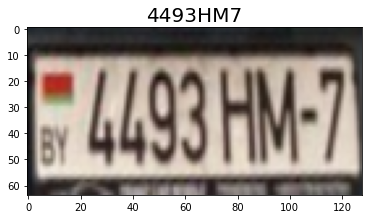

In [13]:
img, ann = train_dataset[np.random.randint(len(train_dataset))]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.title(ann, fontdict={"fontsize" : 20});

###Dataset definition

In [14]:
train_dataset = NumberplateDataset('autoriaNumberplateOcrBy-2020-10-09/train', transform=transform)
test_dataset = NumberplateDataset('autoriaNumberplateOcrBy-2020-10-09/test', transform=transform)
valid_dataset = NumberplateDataset('autoriaNumberplateOcrBy-2020-10-09/val', transform=transform)
print("Train", len(train_dataset))
print("Test", len(test_dataset))
print("Valid", len(valid_dataset))

Train 11020
Test 1212
Valid 854


### DataLoaders

In [15]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Label Converter

In [64]:
class LabelConverter(object):

  def __init__(self, alphabet: str, ignore_case: bool = True):
    self._ignore_case = ignore_case
    if self._ignore_case:
      alphabet = alphabet.lower()
    self.alphabet = alphabet + '-'  # for `-1` index

    self.char2idx = {'-' : 0}
    for i, char in enumerate(alphabet):
      self.char2idx[char] = i + 1
    self.idx2char = {idx: char for char, idx in self.char2idx.items()}

  def encode(self, text):
    if isinstance(text, str):
      text = [
        self.char2idx[char.lower() if self._ignore_case else char]
        for char in text]
      length = [len(text)]
    elif isinstance(text, collections.Iterable):
      length = [len(s) for s in text]
      text = ''.join(text)
      text, _ = self.encode(text)
    return (torch.IntTensor(text), torch.IntTensor(length))

  def decode(self, t, length, raw=False):
    if length.numel() == 1:
      length = length[0]
      assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
      if raw:
        return ''.join([self.alphabet[i - 1] for i in t])
      else:
        char_list = []
        for i in range(length):
          if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
            char_list.append(self.alphabet[t[i] - 1])
        return ''.join(char_list)
    else:
        # batch mode
      assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
      texts = []
      index = 0
      for i in range(length.numel()):
        l = length[i]
        texts.append(
        self.decode(t[index:index + l], torch.IntTensor([l]), raw=raw))
        index += l
    return texts


def decode_prediction(logits: torch.Tensor, 
                      label_converter: LabelConverter) -> str:
  tokens = logits.softmax(2).argmax(2)
  tokens = tokens.squeeze(1).numpy()
  #print(tokens)
  # convert tor stings tokens
  tokens = ''.join([label_converter.idx2char[token] 
                    if token != 0  else '-' 
                    for token in tokens])
  #print(tokens)
  tokens = tokens.split('-')
  #print(tokens)

  # remove duplicates
  #text = [char 
  #        for batch_token in tokens 
  #        for idx, char in enumerate(batch_token)
  #        if char != batch_token[idx-1] or len(batch_token) == 1]
  #text = ''.join(text)
  #print(text)
  #return text
  return ''.join(tokens)

In [84]:
class LabelConverter(object):
  def __init__(self, letters: str,
                max_text_len: int,
                ignore_case: bool = True):
    self._ignore_case = ignore_case
    if self._ignore_case:
        letters = letters.lower()
    self.letters = letters
    self.letters_max = len(self.letters) + 1
    self.max_text_len = max_text_len
    
  def labels_to_text(self, labels: List) -> str:
    out_best = [k for k, g in itertools.groupby(labels)]
    outstr = ''
    for c in out_best:
        if c != 0:
            outstr += self.letters[c - 1]
    return outstr

  def encode(self, text):
    """Support batch or single str.
    Args:
        text (str or list of str): texts to convert.
    Returns:
        torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
        torch.IntTensor [n]: length of each text.
    """
    length = []
    if isinstance(text, str):
        text = list(map(lambda x: self.letters.index(x) + 1, text))
        while len(text) < self.max_text_len:
            text.append(0)
        length = [len(text)]
    elif isinstance(text, collections.Iterable):
        length = [len(s) for s in text]
        text = ''.join(text)
        text, _ = self.encode(text)
    return torch.IntTensor(text), torch.IntTensor(length)

  def decode(self, t, length):
    """Decode encoded texts back into strs.
    Args:
        torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
        torch.IntTensor [n]: length of each text.
    Raises:
        AssertionError: when the texts and its length does not match.
    Returns:
        text (str or list of str): texts to convert.
    """
    if length.numel() == 1:
        length = length[0]
        assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(),
                                                                                                      length)
        out_best = list(np.argmax(t[0, :], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c != 0:
                outstr += self.letters[c - 1]
        return outstr
    else:
        # batch mode
        assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(
            t.numel(), length.sum())
        texts = []
        index = 0
        for i in range(length.numel()):
            texts.append(
                self.decode(
                    t[index:index + length[i]], torch.IntTensor([length[i]])))
            index += length[i]
    return texts


def decode_prediction(logits: torch.Tensor,
                      label_converter: LabelConverter) -> str:
  tokens = logits.softmax(2).argmax(2)
  tokens = tokens.squeeze(1).numpy()

  text = label_converter.labels_to_text(tokens)
  return text


def decode_batch(net_out_value: torch.Tensor,
                 label_converter: LabelConverter) -> str or List:
  texts = []
  for i in range(net_out_value.shape[1]):
      logits = net_out_value[:, i:i+1, :]
      pred_texts = decode_prediction(logits, label_converter)
      texts.append(pred_texts)
  return texts


def is_valid_str(s: str, letters: List) -> bool:
  for ch in s:
      if ch not in letters:
          return False
  return True

## OCR for belarusian numberplates

In [87]:
alphabet = ''.join(letters)
label_converter = LabelConverter(alphabet, max_text_len=8, ignore_case=False)
print(len(letters))

22


In [88]:
alphabet

'0123456789ABCEHIKMOPTX'

In [89]:
label_converter.alphabet, label_converter.char2idx, label_converter.idx2char

AttributeError: ignored

In [90]:
annotation = train_dataset[np.random.randint(len(train_dataset))][1]
print(annotation)

8150HP7


In [91]:
label_converter.encode(annotation)

(tensor([ 9,  2,  6,  1, 15, 20,  8,  0], dtype=torch.int32),
 tensor([8], dtype=torch.int32))

In [92]:
model = OCR(letters, bidirectional=True).to(device)

In [93]:
lr = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=lr, nesterov=True, 
                            weight_decay=1e-5, momentum=0.9)
criterion = nn.CTCLoss(blank=0)

In [94]:
def calculate_loss(criterion, logits, texts, label_converter):
  # get infomation from prediction
  input_len, batch_size, vocab_size = logits.size()
  # encode inputs
  logits = logits.log_softmax(2)
  encoded_texts, text_lens = label_converter.encode(texts)
  #print(encoded_texts, text_lens)
  logits_lens = torch.full(size=(batch_size,), fill_value=input_len, dtype=torch.int32)
  #print(logits, logits_lens)
  # calculate ctc
  loss = criterion(logits, encoded_texts,
                    logits_lens.to(device), text_lens)
  return loss

In [95]:
def accuracy_calculation(model, dataset, label_converter) -> float:
    acc = 0
    model.eval()
    with torch.no_grad():
        model.eval()
        for idx in range(len(dataset)):
            img, text = dataset[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred_text = decode_prediction(logits.cpu(), label_converter)
            
            if pred_text == text:
                acc += 1
            
    return acc / len(dataset)

In [96]:
def validation(model, criterion, valid_dataloader, label_converter):
  model.eval()
  val_losses = []
  with torch.no_grad():
    model.eval()
    running_loss = 0
    for batch_image, batch_text in tqdm(valid_dataloader):
      logits = model(batch_image.to(device))
      val_loss = calculate_loss(criterion, logits, batch_text, label_converter)
      val_losses.append(val_loss.item())
  return np.array(val_losses).mean()

In [97]:
def train(model, optimizer, criterion, train_dataloader, label_converter):
  model.train()
  train_losses = []
  for batch_imgs, batch_text in tqdm(train_dataloader):
    optimizer.zero_grad()
    logits = model(batch_imgs.to(device))
    # calculate loss
    train_loss = calculate_loss(criterion, logits, batch_text, label_converter)
    if np.isnan(train_loss.detach().cpu().numpy()):
      continue
    train_losses.append(train_loss.item())
    # make backward
    train_loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
    optimizer.step()
  return np.array(train_losses).mean()

In [128]:
def fit(model, optimizer, criterion, train_dataloader, valid_dataloader, label_converter, epochs):
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  for i in trange(epochs):
    print(f"Epoch {i + 1}")

    train_loss = train(model, optimizer, criterion, train_dataloader, label_converter)
    train_accuracy = accuracy_calculation(model, train_dataloader.dataset, label_converter)
    #train_accuracy = "Not calculated"
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    valid_loss = validation(model, criterion, valid_dataloader, label_converter)
    valid_accuracy = accuracy_calculation(model, valid_dataloader.dataset, label_converter)
    val_accuracies.append(valid_accuracy)
    val_losses.append(valid_loss)
    print(f"Train accuracy: {train_accuracy}, Valid accuracy: {valid_accuracy}, Train loss: {train_loss}, Valid loss: {valid_loss}")
  return train_losses, val_losses, train_accuracies, val_accuracies

In [101]:
train_losses, val_losses, train_accuracies, val_accuracies = \
fit(model, optimizer, criterion, train_dataloader, valid_dataloader, label_converter, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.0, Train loss: 2.531699151662044, Valid loss: 2.4489272321973528
Epoch 2


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.0, Train loss: 2.2419705294460233, Valid loss: 2.0857434443065097
Epoch 3


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.00117096018735363, Train loss: 1.9307733450321793, Valid loss: 1.8821322917938232
Epoch 4


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.09133489461358314, Train loss: 1.365447790981028, Valid loss: 1.2880329149109977
Epoch 5


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.3700234192037471, Train loss: 0.6913280142525028, Valid loss: 0.8877509023462024
Epoch 6


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.5175644028103045, Train loss: 0.39659355348245257, Valid loss: 0.6383057492119926
Epoch 7


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.5585480093676815, Train loss: 0.29763013753243267, Valid loss: 0.6448612894330706
Epoch 8


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.7740046838407494, Train loss: 0.20945379221973393, Valid loss: 0.17076510696538857
Epoch 9


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.7822014051522248, Train loss: 0.1396477574730195, Valid loss: 0.14283553723778045
Epoch 10


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8021077283372365, Train loss: 0.1122846058166096, Valid loss: 0.12110242540282863
Epoch 11


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.7576112412177985, Train loss: 0.11094284083457351, Valid loss: 0.23516211552279337
Epoch 12


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.7985948477751756, Train loss: 0.08718748774508693, Valid loss: 0.12124031143529075
Epoch 13


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.7857142857142857, Train loss: 0.06862038181222588, Valid loss: 0.1286556805883135
Epoch 14


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.7517564402810304, Train loss: 0.07339514183644959, Valid loss: 0.29027266587529865
Epoch 15


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.7822014051522248, Train loss: 0.045525752885450174, Valid loss: 0.19966921050633704
Epoch 16


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8266978922716628, Train loss: 0.038542380454180215, Valid loss: 0.10190618996109281
Epoch 17


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8442622950819673, Train loss: 0.02360956786830258, Valid loss: 0.0776057042447584
Epoch 18


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8454332552693209, Train loss: 0.01179692822890733, Valid loss: 0.07730614633432456
Epoch 19


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.7740046838407494, Train loss: 0.02680396801802852, Valid loss: 0.12957520969212055
Epoch 20


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8032786885245902, Train loss: 0.030199193829035312, Valid loss: 0.1492345311811992
Epoch 21


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8302107728337237, Train loss: 0.01950347646155712, Valid loss: 0.10046311574322837
Epoch 22


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8091334894613583, Train loss: 0.019363547379226353, Valid loss: 0.11120924619691712
Epoch 23


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8512880562060889, Train loss: 0.012584408944354237, Valid loss: 0.07942188783947911
Epoch 24


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8477751756440282, Train loss: 0.005134323381380087, Valid loss: 0.07947106366711003
Epoch 25


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8524590163934426, Train loss: 0.003791685472175242, Valid loss: 0.07306359388998576
Epoch 26


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8524590163934426, Train loss: 0.0033095966445179817, Valid loss: 0.07342008128762245
Epoch 27


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8524590163934426, Train loss: 0.0026032407562829813, Valid loss: 0.07134226110896894
Epoch 28


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8489461358313818, Train loss: 0.0024418097794879595, Valid loss: 0.0737404668304537
Epoch 29


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8524590163934426, Train loss: 0.002355637613581655, Valid loss: 0.0737319665162691
Epoch 30


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8536299765807962, Train loss: 0.002223911960986093, Valid loss: 0.07326778663056237
Epoch 31


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8512880562060889, Train loss: 0.0021041955108615715, Valid loss: 0.07596914270626647
Epoch 32


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8548009367681498, Train loss: 0.0021658744617577943, Valid loss: 0.07402138731309346
Epoch 33


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8512880562060889, Train loss: 0.0019132063570674617, Valid loss: 0.0740273333420711
Epoch 34


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8524590163934426, Train loss: 0.0018481619086121936, Valid loss: 0.07424149788650018
Epoch 35


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8407494145199064, Train loss: 0.005353503891487601, Valid loss: 0.09499680769762822
Epoch 36


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8442622950819673, Train loss: 0.004724501303936802, Valid loss: 0.09938352834433317
Epoch 37


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8524590163934426, Train loss: 0.005151113568579057, Valid loss: 0.08986135671979614
Epoch 38


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8477751756440282, Train loss: 0.0033632714482699924, Valid loss: 0.0919130737228053
Epoch 39


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.860655737704918, Train loss: 0.0022830556360789378, Valid loss: 0.08357157684596521
Epoch 40


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8571428571428571, Train loss: 0.002061186816591791, Valid loss: 0.08761585064764534
Epoch 41


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8583138173302107, Train loss: 0.0020040183317493595, Valid loss: 0.08598347174535904
Epoch 42


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8594847775175644, Train loss: 0.001961975661240992, Valid loss: 0.08219543531803149
Epoch 43


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8044496487119438, Train loss: 0.003898971804755476, Valid loss: 0.18819379088069713
Epoch 44


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8430913348946136, Train loss: 0.006727162367365501, Valid loss: 0.10182349476963282
Epoch 45


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8477751756440282, Train loss: 0.002221932756678185, Valid loss: 0.08497386838176421
Epoch 46


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8489461358313818, Train loss: 0.001444808859849144, Valid loss: 0.08478390744754247
Epoch 47


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8501170960187353, Train loss: 0.001292401895709632, Valid loss: 0.08176966972782143
Epoch 48


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8501170960187353, Train loss: 0.0012479366487661925, Valid loss: 0.08243678470275231
Epoch 49


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8536299765807962, Train loss: 0.0012020487841312918, Valid loss: 0.08094700898176857
Epoch 50


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: Not calculated, Valid accuracy: 0.8512880562060889, Train loss: 0.0011781656070251685, Valid loss: 0.08200440835207701


In [135]:
first_exp_result = {"Train losses" : train_losses, 
                    "Valid losses" : val_losses, 
                    "Train accuracies" : train_accuracies,
                    "Valid accuracies" : val_accuracies}
with open('ocr_exps/first_exp_result.json', 'w') as json_file:
    json.dump(first_exp_result, json_file)

In [102]:
def print_prediction(model, dataset, label_converter):
  idx = np.random.randint(len(dataset))
  path = dataset.images_pathes[idx]
  
  model.eval()
  with torch.no_grad():
    img, target_text = dataset[idx]
    img = img.unsqueeze(0)
    logits = model(img.to(device))
  #print(logits.shape)  
  pred_text = decode_prediction(logits.cpu(), label_converter)

  img = np.asarray(Image.open(path).convert('RGB'))
  title = f'Truth: {target_text} | Pred: {pred_text}'
  plt.imshow(img)
  plt.title(title)
  plt.axis('off');

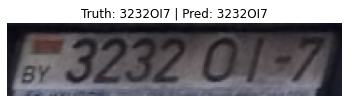

In [122]:
print_prediction(model, test_dataset, label_converter)

## Saving results

In [123]:
!mkdir ocr_exps

In [124]:
PATH = "ocr_exps/ocr_model_lr=0.02_epochs=50_val_acc=0.85.pth"

In [125]:
torch.save(model.state_dict(), PATH)

In [126]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

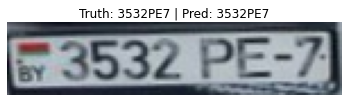

In [127]:
print_prediction(model, test_dataset, label_converter)

## Another way to train

In [129]:
model = OCR(letters, bidirectional=True).to(device)

In [132]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr, nesterov=True, 
                            weight_decay=1e-5, momentum=0.9)
criterion = nn.CTCLoss(blank=0)

In [133]:
train_losses_s, val_losses_s, train_accuracies_s, val_accuracies_s = \
fit(model, optimizer, criterion, train_dataloader, valid_dataloader, label_converter, 60)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.0, Valid accuracy: 0.0, Train loss: 2.6271333804709376, Valid loss: 2.5769665581839427
Epoch 2


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.0, Valid accuracy: 0.0, Train loss: 2.425863691148041, Valid loss: 2.4515645503997803
Epoch 3


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.0, Valid accuracy: 0.0, Train loss: 2.2286158999955723, Valid loss: 2.1550528832844327
Epoch 4


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.0, Valid accuracy: 0.0, Train loss: 2.0534033479029046, Valid loss: 2.0772986156599864
Epoch 5


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.001088929219600726, Valid accuracy: 0.00234192037470726, Train loss: 1.8361045259960813, Valid loss: 1.7846455233437675
Epoch 6


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.019600725952813067, Valid accuracy: 0.02107728337236534, Train loss: 1.4572064676725796, Valid loss: 1.3183517711503165
Epoch 7


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.17450090744101635, Valid accuracy: 0.1873536299765808, Train loss: 0.9822473884317916, Valid loss: 0.8766005166939327
Epoch 8


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.4966424682395644, Valid accuracy: 0.5292740046838408, Train loss: 0.5908957311528267, Valid loss: 0.4220314919948578
Epoch 9


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.6361161524500908, Valid accuracy: 0.6194379391100703, Train loss: 0.3430853469695659, Valid loss: 0.2844484725168773
Epoch 10


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.6793103448275862, Valid accuracy: 0.6662763466042154, Train loss: 0.22632263751560552, Valid loss: 0.2554956812943731
Epoch 11


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.7181488203266788, Valid accuracy: 0.7002341920374707, Train loss: 0.1707378793400147, Valid loss: 0.21170487041984284
Epoch 12


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.7509074410163339, Valid accuracy: 0.6920374707259953, Train loss: 0.12716418433654514, Valid loss: 0.2427045085600444
Epoch 13


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8203266787658802, Valid accuracy: 0.7903981264637002, Train loss: 0.10925853069376394, Valid loss: 0.14752748821462905
Epoch 14


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8010889292196007, Valid accuracy: 0.7447306791569087, Train loss: 0.08149426050398047, Valid loss: 0.24229267026696885
Epoch 15


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8447368421052631, Valid accuracy: 0.7927400468384075, Train loss: 0.06986640372200509, Valid loss: 0.15475080907344818
Epoch 16


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8613430127041742, Valid accuracy: 0.7868852459016393, Train loss: 0.058878677697970686, Valid loss: 0.15152250975370407
Epoch 17


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.861524500907441, Valid accuracy: 0.7927400468384075, Train loss: 0.042252829540628575, Valid loss: 0.1870986039617232
Epoch 18


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8843920145190562, Valid accuracy: 0.8079625292740047, Train loss: 0.03475745531294301, Valid loss: 0.13437288201281003
Epoch 19


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8918330308529946, Valid accuracy: 0.8114754098360656, Train loss: 0.02431122594744484, Valid loss: 0.1455332820436784
Epoch 20


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8888384754990926, Valid accuracy: 0.8360655737704918, Train loss: 0.020848418585956097, Valid loss: 0.12033190431871585
Epoch 21


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.89010889292196, Valid accuracy: 0.8255269320843092, Train loss: 0.02127304623937073, Valid loss: 0.12726838620645659
Epoch 22


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8929219600725953, Valid accuracy: 0.8161592505854801, Train loss: 0.018893104439569004, Valid loss: 0.14138149789401463
Epoch 23


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8987295825771325, Valid accuracy: 0.8360655737704918, Train loss: 0.014422463530383876, Valid loss: 0.11696821304836444
Epoch 24


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8857531760435572, Valid accuracy: 0.8149882903981265, Train loss: 0.0198462251829511, Valid loss: 0.1442667551870857
Epoch 25


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8942831215970962, Valid accuracy: 0.8278688524590164, Train loss: 0.018310881518581183, Valid loss: 0.12835103047213384
Epoch 26


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8892014519056262, Valid accuracy: 0.8173302107728337, Train loss: 0.011384985916386493, Valid loss: 0.13706037774682045
Epoch 27


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.9003629764065336, Valid accuracy: 0.8302107728337237, Train loss: 0.011924426928647078, Valid loss: 0.11203962391508478
Epoch 28


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8981851179673321, Valid accuracy: 0.8220140515222483, Train loss: 0.007547257892044552, Valid loss: 0.1535979410899537
Epoch 29


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.9019963702359347, Valid accuracy: 0.8395784543325527, Train loss: 0.0049860608048004915, Valid loss: 0.11941616929003171
Epoch 30


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.9013611615245009, Valid accuracy: 0.8173302107728337, Train loss: 0.004414880688630604, Valid loss: 0.1655041782983712
Epoch 31


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.8964609800362976, Valid accuracy: 0.8302107728337237, Train loss: 0.007375319124969272, Valid loss: 0.13329444120505027
Epoch 32


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.9005444646098003, Valid accuracy: 0.8395784543325527, Train loss: 0.005915373137807527, Valid loss: 0.13224151038697787
Epoch 33


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902087114337568, Valid accuracy: 0.8384074941451991, Train loss: 0.006619842196114878, Valid loss: 0.1267190221697092
Epoch 34


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.9027223230490018, Valid accuracy: 0.8395784543325527, Train loss: 0.003162735941916747, Valid loss: 0.11992782434182507
Epoch 35


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.9027223230490018, Valid accuracy: 0.8407494145199064, Train loss: 0.0024976916547267123, Valid loss: 0.12091128089066062
Epoch 36


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.9029038112522686, Valid accuracy: 0.8454332552693209, Train loss: 0.0021347217504042765, Valid loss: 0.11695698595472745
Epoch 37


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8454332552693209, Train loss: 0.0019393104883556852, Valid loss: 0.11440917224224124
Epoch 38


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8477751756440282, Train loss: 0.0017374222098871248, Valid loss: 0.11399748109813247
Epoch 39


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8466042154566745, Train loss: 0.001676150390876974, Valid loss: 0.1155531858759267
Epoch 40


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8489461358313818, Train loss: 0.0016186299365056904, Valid loss: 0.11354388336517982
Epoch 41


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8477751756440282, Train loss: 0.0015758534087907156, Valid loss: 0.11354558050100293
Epoch 42


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8454332552693209, Train loss: 0.001552373126271649, Valid loss: 0.11267391485827309
Epoch 43


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8477751756440282, Train loss: 0.0015243965265343794, Valid loss: 0.11472914381218809
Epoch 44


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8477751756440282, Train loss: 0.0015096712411338238, Valid loss: 0.11488942043589694
Epoch 45


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8512880562060889, Train loss: 0.0014802680347139026, Valid loss: 0.113897575730724
Epoch 46


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8466042154566745, Train loss: 0.001455133382972556, Valid loss: 0.11486655859542745
Epoch 47


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8524590163934426, Train loss: 0.0014383513086766134, Valid loss: 0.11315617417650563
Epoch 48


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8512880562060889, Train loss: 0.001412783100201097, Valid loss: 0.11281275083976132
Epoch 49


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8536299765807962, Train loss: 0.0013889479336484923, Valid loss: 0.11425708846322127
Epoch 50


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8512880562060889, Train loss: 0.002623774454965272, Valid loss: 0.11401872429996729
Epoch 51


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8524590163934426, Train loss: 0.0013588340106794362, Valid loss: 0.11254537770790714
Epoch 52


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8548009367681498, Train loss: 0.001351719183815008, Valid loss: 0.11563325393944979
Epoch 53


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8466042154566745, Train loss: 0.001417056190366776, Valid loss: 0.11815271047609192
Epoch 54


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8501170960187353, Train loss: 0.0013910567379863449, Valid loss: 0.11936244647949934
Epoch 55


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8512880562060889, Train loss: 0.001343063163440513, Valid loss: 0.11569388849394661
Epoch 56


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8501170960187353, Train loss: 0.001328068141384061, Valid loss: 0.11559145751276187
Epoch 57


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8489461358313818, Train loss: 0.0013167723873529229, Valid loss: 0.11539136618375778
Epoch 58


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8489461358313818, Train loss: 0.0013012071737327823, Valid loss: 0.11429158185741731
Epoch 59


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8501170960187353, Train loss: 0.0012853766702024018, Valid loss: 0.11617202391581875
Epoch 60


  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Train accuracy: 0.902994555353902, Valid accuracy: 0.8489461358313818, Train loss: 0.0012811633833614043, Valid loss: 0.11616170233381647


In [136]:
PATH = "ocr_exps/ocr_model_lr=0.01_epochs=60_val_acc=0.85.pth"

In [137]:
torch.save(model.state_dict(), PATH)

In [138]:
second_exp_result = {"Train losses" : train_losses_s, 
                    "Valid losses" : val_losses_s, 
                    "Train accuracies" : train_accuracies_s,
                    "Valid accuracies" : val_accuracies_s}
with open('ocr_exps/second_exp_result.json', 'w') as json_file:
    json.dump(second_exp_result, json_file)